<a href="https://colab.research.google.com/github/nicolesaade/WorldHappinessReportAnalysis/blob/main/WorldHappinessReport_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#3. Predict 2023 Life Ladder

In [32]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Dropout

##3(a) Load Life Ladder Score



In [33]:
import statsmodels.api as sm
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('happiness_dataset.csv')

# Normalize data
scaler = StandardScaler()
data['Life Ladder'] = scaler.fit_transform(data[['Life Ladder']])

# Dataframe with life ladder score 2018-2023
ladder_data = data[['Country name', 'year', 'Life Ladder']].loc[data['year'].isin([2018, 2019, 2020, 2021, 2022, 2023])]

# Remove countries missing any of the 2018-2023 life ladder scores
countries = set(ladder_data.loc[ladder_data['year']==2018]['Country name'].unique()).intersection(
    ladder_data.loc[ladder_data['year']==2019]['Country name'].unique(),
    ladder_data.loc[ladder_data['year']==2020]['Country name'].unique(),
    ladder_data.loc[ladder_data['year']==2021]['Country name'].unique(),
    ladder_data.loc[ladder_data['year']==2022]['Country name'].unique(),
    ladder_data.loc[ladder_data['year']==2023]['Country name'].unique()
)
ladder_data = ladder_data.loc[ladder_data['Country name'].isin(countries)]

# Show all the countries using df.head()
ladder_data.head(-1)

,Country name,year,Life Ladder
25,Albania,2018,-0.426173
26,Albania,2019,-0.434171
27,Albania,2020,-0.105365
28,Albania,2021,-0.203118
29,Albania,2022,-0.241331
...,...,...,...
2357,Zimbabwe,2018,-1.659641
2358,Zimbabwe,2019,-2.478990
2359,Zimbabwe,2020,-2.064872
2360,Zimbabwe,2021,-2.069315


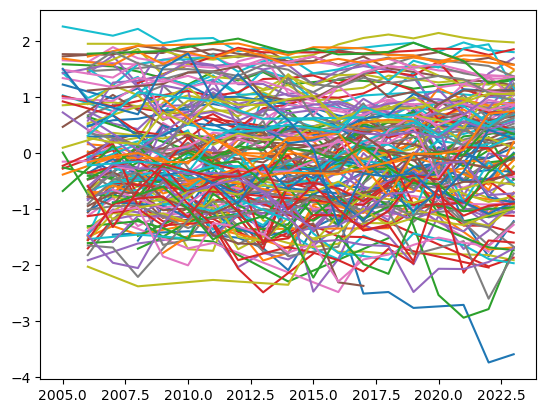

In [34]:
import matplotlib.pyplot as plt

for country in data['Country name'].unique():
  plt.plot(data.loc[data['Country name']==country]['year'], data.loc[data['Country name']==country]['Life Ladder'])

##3(b) LSTM

In [35]:
predictions = {}
for country in countries:
    country_data = ladder_data.loc[ladder_data['Country name']==country]
    X = country_data['Life Ladder'].values.reshape(-1, 1)
    
    X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
    
    model = Sequential()
    model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, X_train, epochs=100, verbose=0)
    
    lstm_preds = model.predict(X_test)
    
    regressor = LinearRegression()
    regressor.fit(lstm_preds, X_test)
    
    last_ladder = X[-1]
    forecast = []
    for _ in range(5):
        lstm_preds = model.predict(last_ladder.reshape(-1, 1))
        prediction = regressor.predict(lstm_preds)
        forecast.append(prediction[0,0])
        last_ladder = prediction
    
    predictions[country] = forecast

1/1 [==============================] - 0s 12ms/step


##3(c) Linear Regression (for other features)

In [36]:
for country, forecast in predictions.items():
    predicted = pd.DataFrame({'Year': range(2024, 2029), 'Life Ladder': forecast})
    
    X_pred = predicted['Year'].values.reshape(-1, 1)
    y_pred = predicted['Life Ladder'].values.reshape(-1, 1)
    
    regressor = LinearRegression()
    regressor.fit(X_pred, y_pred)
    
    years = np.array(range(2024, 2029)).reshape(-1, 1)
    lr_preds = regressor.predict(years)

In [37]:
from plotly import graph_objects as go

# Calculate the happiness score increase/decrease and final happiness score for each country
country_stats = []
for country, forecast in predictions.items():
    initial_score = forecast[0]
    final_score = forecast[-1]
    change = final_score - initial_score
    country_stats.append((country, change, final_score))

# Sort the countries based on the happiness score increase/decrease and final happiness score
country_stats.sort(key=lambda x: (x[1], x[2]), reverse=True)

# Create traces for each country's predicted happiness scores
traces = []
for country, _, _ in country_stats:
    predicted = pd.DataFrame({'Year': range(2024, 2029), 'Life Ladder': predictions[country]})
    trace = go.Scatter(x=predicted['Year'], y=predicted['Life Ladder'], mode='lines+markers', name=country)
    traces.append(trace)

# Create the layout for the plot
layout = go.Layout(
    title='Predicted Life Ladder for All Countries',
    xaxis=dict(title='Year'),
    yaxis=dict(title='Life Ladder'),
    hovermode='closest',
    width=800,
    height=600
)

# Create the figure and display the plot
fig = go.Figure(data=traces, layout=layout)
fig.show()

# Print the ranking of countries based on happiness score increase/decrease and final happiness score
print("Ranking of Countries:")
for i, (country, change, final_score) in enumerate(country_stats, start=1):
    print(f"{i}. {country}: Increase/Decrease = {change:.4f}, Final Score = {final_score:.4f}")

Ranking of Countries:
1. Bulgaria: Increase/Decrease = 29.3006, Final Score = 30.0274
2. Vietnam: Increase/Decrease = 2.2530, Final Score = 3.1952
3. South Africa: Increase/Decrease = 1.4495, Final Score = 1.1239
4. Mexico: Increase/Decrease = 0.3527, Final Score = 1.7532
5. Malaysia: Increase/Decrease = 0.3495, Final Score = 0.7373
6. Kosovo: Increase/Decrease = 0.3485, Final Score = 1.6332
7. Poland: Increase/Decrease = 0.2969, Final Score = 1.4073
8. Saudi Arabia: Increase/Decrease = 0.2433, Final Score = 1.5861
9. Argentina: Increase/Decrease = 0.2306, Final Score = 1.0726
10. Croatia: Increase/Decrease = 0.1669, Final Score = 0.6150
11. Ecuador: Increase/Decrease = 0.1590, Final Score = 0.5203
12. Romania: Increase/Decrease = 0.1590, Final Score = 1.0776
13. Austria: Increase/Decrease = 0.1576, Final Score = 1.2476
14. Estonia: Increase/Decrease = 0.1500, Final Score = 1.0156
15. Switzerland: Increase/Decrease = 0.1453, Final Score = 1.5240
16. Lithuania: Increase/Decrease = 0.141